*Library and Installation*

In [1]:
%pip install unsloth
%pip install --upgrade --force-reinstall --no-cache-dir unsloth unsloth_zoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 3.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.1/376.1 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.7/290.7 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/

*Initial Structure*

In [2]:
from unsloth import tokenizer_utils
def do_nothing(*args, **kwargs):
    pass
tokenizer_utils.fix_untrained_tokens = do_nothing

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
import os
import warnings
from typing import Any, Dict, List, Tuple, Union

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split

from transformers import (
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
)

from trl import SFTTrainer
from unsloth import FastLanguageModel


# ---------------------------
# GPU INFORMATION
# ---------------------------
major_version, minor_version = torch.cuda.get_device_capability()
print(f"Major: {major_version}, Minor: {minor_version}")


# ---------------------------
# MODEL LIST
# ---------------------------
used_models = [
    "unsloth/Qwen3-0.6B-Base-unsloth-bnb-4bit",
    "unsloth/Qwen3-1.7B-Base-unsloth-bnb-4bit",
    "unsloth/Qwen3-4B-Base-unsloth-bnb-4bit",
    "unsloth/Qwen3-8B-Base-unsloth-bnb-4bit",
    "unsloth/Qwen3-14B-Base-unsloth-bnb-4bit",
]

NUM_CLASSES = 2
max_seq_length = 2048
dtype = None  # Auto detection


# ---------------------------
# MODEL SELECTION
# ---------------------------
model_name = "unsloth/Qwen3-0.6B-Base-unsloth-bnb-4bit"
load_in_4bit = True


# ---------------------------
# MODEL LOADING
# ---------------------------
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    load_in_4bit=load_in_4bit,
    max_seq_length=max_seq_length,
    dtype=dtype,
)

Major: 7, Minor: 5
==((====))==  Unsloth 2025.12.9: Fast Qwen3 patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/567M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

In [4]:
number_token_ids = []
for i in range(0, NUM_CLASSES+1):
    number_token_ids.append(tokenizer.encode(str(i), add_special_tokens=False)[0])
par = torch.nn.Parameter(model.lm_head.weight[number_token_ids, :])

old_shape = model.lm_head.weight.shape
old_size = old_shape[0]
print(par.shape)
print(old_shape)

model.lm_head.weight = par

reverse_map = {value: idx for idx, value in enumerate(number_token_ids)} # will be used later to convert an idx from the old tokenizer to the new lm_head
reverse_map

torch.Size([3, 1024])
torch.Size([151936, 1024])


{15: 0, 16: 1, 17: 2}

In [5]:
from peft import LoftQConfig

model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = [
        "lm_head",
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = True,
)
print("trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Unsloth: Offloading output_embeddings to disk to save VRAM


/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:1222: UserWarning: Model has `tie_word_embeddings=True` and a tied layer is part of the adapter, but `ensure_weight_tying` is not set to True. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. Check the discussion here: https://github.com/huggingface/peft/issues/2777
  warnings.warn(msg)
Unsloth 2025.12.9 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


Unsloth: Training lm_head in mixed precision to save VRAM
trainable parameters: 10095616


*Data*

3030


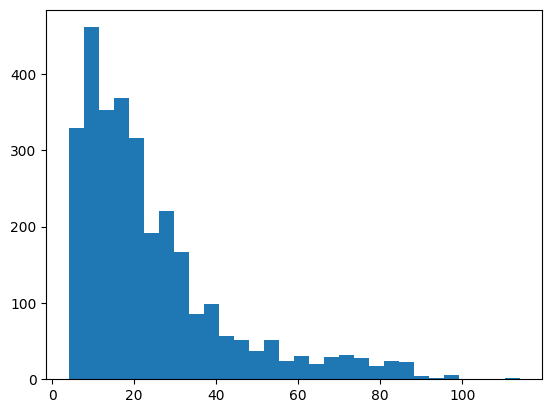

In [6]:
data = pd.read_csv("/content/Boamente_Treino_Atualizado.csv")
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)
print(len(train_df))

token_counts = [len(tokenizer.encode(x)) for x in train_df.text]
a = plt.hist(token_counts, bins=30)

*Prompt and Data Collator*

In [7]:
from datasets import Dataset

prompt = """Aqui está uma sentença.
{}

Se a sentença contém ideação suicida, responda "Sim". Caso contrário, responda "Não":

A resposta correta é: "{}"""

positivelabel = "Sim" #Yes
negativelabel = "Não" #No

def formatting_prompts_func(dataset_):
    texts = []
    for i in range(len(dataset_['text'])):
        text_ = dataset_['text'].iloc[i]
        label_ = dataset_['label'].iloc[i] #the csv is setup so that the label column corresponds exactly to the 3 classes defined above in the prompt (important)

        text = prompt.format(text_, label_)

        texts.append(text)
    return texts

#apply formatting_prompts_func to train_df
train_df['text'] = formatting_prompts_func(train_df)
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)

In [8]:
class DataCollatorForLastTokenLM(DataCollatorForLanguageModeling):
    def __init__(
        self,
        *args,
        mlm: bool = False,
        ignore_index: int = -100,
        **kwargs,
    ):
        super().__init__(*args, mlm=mlm, **kwargs)
        self.ignore_index = ignore_index

    def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:
        batch = super().torch_call(examples)

        for i in range(len(examples)):
            last_token_idx = (batch["labels"][i] != self.ignore_index).nonzero()[-1].item()
            batch["labels"][i, :last_token_idx] = self.ignore_index
            batch["labels"][i, last_token_idx] = reverse_map[ batch["labels"][i, last_token_idx].item() ]
        return batch
collator = DataCollatorForLastTokenLM(tokenizer=tokenizer)

*Training with Cross-Validation*

In [14]:
import sys
import types

psutil_mock = types.SimpleNamespace(
    cpu_count=lambda logical=True: 1,
    virtual_memory=lambda: types.SimpleNamespace(available=8 * 1024**3)
)

sys.modules["psutil"] = psutil_mock


In [15]:
# =====================================
# IMPORTS
# =====================================
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import TrainingArguments
from trl import SFTTrainer

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve

from datasets import Dataset
from scipy.special import softmax


# =====================================
# CONFIG
# =====================================
NUM_FOLDS = 5
SEED = 3407
OUTPUT_DIR = "/content/roc_cv_results"

os.makedirs(OUTPUT_DIR, exist_ok=True)

torch.manual_seed(SEED)
np.random.seed(SEED)


# =====================================
# DATASET
# =====================================
full_dataset = Dataset.from_pandas(train_df, preserve_index=False)

skf = StratifiedKFold(
    n_splits=NUM_FOLDS,
    shuffle=True,
    random_state=SEED
)


# =====================================
# STORAGE
# =====================================
fold_results = []
roc_curves = []   # (fpr, tpr, auc)


# =====================================
# CROSS-VALIDATION
# =====================================
for fold, (train_idx, val_idx) in enumerate(
    skf.split(full_dataset["text"], full_dataset["label"])
):

    print(f"\n🚀 Starting Fold {fold+1}/{NUM_FOLDS}")

    train_dataset = full_dataset.select(train_idx)
    val_dataset   = full_dataset.select(val_idx)

    # =====================================
    # TRAINING ARGS (🔥 dataset_num_proc FIXADO)
    # =====================================
    training_args = TrainingArguments(
        per_device_train_batch_size=32,
        gradient_accumulation_steps=1,
        warmup_steps=10,
        learning_rate=1e-4,
        fp16=not torch.cuda.is_bf16_supported(),
        bf16=torch.cuda.is_bf16_supported(),
        logging_steps=50,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        seed=SEED,
        output_dir=f"/content/outputs/fold_{fold+1}",
        num_train_epochs=1,
        report_to="none",
        group_by_length=True,
    )

    # =====================================
    # TRAINER
    # =====================================
    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        max_seq_length=max_seq_length,
        packing=False,
        args=training_args,
        formatting_func=formatting_prompts_func,
        data_collator=collator,
    )

    # -----------------------------
    # TRAIN
    # -----------------------------
    trainer.train()

    # -----------------------------
    # PREDICT
    # -----------------------------
    predictions = trainer.predict(val_dataset)
    logits = predictions.predictions

    probs = softmax(logits, axis=1)[:, 1]
    y_true = np.array(val_dataset["label"])

    # -----------------------------
    # AUC + ROC
    # -----------------------------
    auc = roc_auc_score(y_true, probs)
    fpr, tpr, _ = roc_curve(y_true, probs)

    # -----------------------------
    # SAVE PER FOLD
    # -----------------------------
    np.save(f"{OUTPUT_DIR}/y_true_fold_{fold+1}.npy", y_true)
    np.save(f"{OUTPUT_DIR}/y_score_fold_{fold+1}.npy", probs)
    np.save(f"{OUTPUT_DIR}/fpr_fold_{fold+1}.npy", fpr)
    np.save(f"{OUTPUT_DIR}/tpr_fold_{fold+1}.npy", tpr)

    fold_results.append({
        "fold": fold + 1,
        "auc": auc
    })

    roc_curves.append((fpr, tpr, auc))

    print(f"📊 Fold {fold+1} | AUC = {auc:.4f}")

    # -----------------------------
    # GPU CLEANUP (IMPORTANTE NO COLAB)
    # -----------------------------
    del trainer, predictions, logits
    torch.cuda.empty_cache()


# =====================================
# RESULTS TABLE
# =====================================
df_results = pd.DataFrame(fold_results)
df_results.to_csv(f"{OUTPUT_DIR}/auc_per_fold.csv", index=False)

mean_auc = df_results["auc"].mean()
std_auc  = df_results["auc"].std()

print("\n📌 AUC por fold:")
display(df_results)

print(f"\n✅ Mean AUC: {mean_auc:.4f} ± {std_auc:.4f}")


# =====================================
# MEAN ROC CURVE
# =====================================
mean_fpr = np.linspace(0, 1, 100)
tprs = []

for fpr, tpr, _ in roc_curves:
    tprs.append(np.interp(mean_fpr, fpr, tpr))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0

np.save(f"{OUTPUT_DIR}/mean_fpr.npy", mean_fpr)
np.save(f"{OUTPUT_DIR}/mean_tpr.npy", mean_tpr)


# =====================================
# PLOT
# =====================================
plt.figure(figsize=(7, 6))
plt.plot(
    mean_fpr,
    mean_tpr,
    linewidth=2,
    label=f"Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})"
)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mean ROC Curve – Stratified 5-Fold CV")
plt.legend()
plt.grid(True)
plt.show()



🚀 Starting Fold 1/5


NameError: name 'psutil' is not defined

In [ ]:
!pip install psutil

In [ ]:
from sklearn.model_selection import StratifiedKFold
import os
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from datasets import Dataset
from transformers import TrainingArguments
from trl import SFTTrainer

num_folds = 5
batch_size = 64
seed = 3407

output_dir = "/home/joaopedro/joaopedro/llm/roc"
os.makedirs(output_dir, exist_ok=True)

# Dataset completo (já formatado com prompt)
full_dataset = Dataset.from_pandas(data, preserve_index=False)

skf = StratifiedKFold(
    n_splits=num_folds,
    shuffle=True,
    random_state=seed
)

all_fold_aucs = []

for fold, (train_idx, val_idx) in enumerate(
    skf.split(full_dataset["text"], full_dataset["label"])
):
    print(f"\n🚀 Starting Fold {fold + 1}/{num_folds}")

    train_dataset = full_dataset.select(train_idx)
    val_dataset   = full_dataset.select(val_idx)

    training_args = TrainingArguments(
        per_device_train_batch_size=32,
        gradient_accumulation_steps=1,
        warmup_steps=10,
        learning_rate=1e-4,
        fp16=not torch.cuda.is_bf16_supported(),
        bf16=torch.cuda.is_bf16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        seed=seed,
        output_dir=f"outputs/fold_{fold}",
        num_train_epochs=1,
        report_to="none",
        group_by_length=True,
    )

    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        max_seq_length=max_seq_length,
        dataset_num_proc=2,
        packing=False,
        args=training_args,
        data_collator=collator,
    )

    trainer.train()

    # ===== Inferência =====
    val_texts  = val_dataset["text"]
    val_labels = val_dataset["label"]

    fold_probabilities = []
    fold_labels = []

    tokenized_inputs = []
    for text, label in zip(val_texts, val_labels):
        # remove resposta do final
        test_str = text.rsplit("A resposta correta é:", 1)[0] + "A resposta correta é:"

        tokenized = tokenizer(
            test_str,
            return_tensors="pt",
            add_special_tokens=False
        )
        tokenized_inputs.append((tokenized, label))

    # ordenar por comprimento
    tokenized_inputs.sort(
        key=lambda x: x[0]["input_ids"].shape[1]
    )

    grouped_inputs = defaultdict(list)
    for tokenized, label in tokenized_inputs:
        length = tokenized["input_ids"].shape[1]
        grouped_inputs[length].append((tokenized, label))

    for length, group in tqdm(grouped_inputs.items()):
        for i in range(0, len(group), batch_size):
            batch = group[i:i + batch_size]

            input_ids = torch.cat(
                [item[0]["input_ids"] for item in batch]
            ).to("cuda")

            attention_mask = torch.cat(
                [item[0]["attention_mask"] for item in batch]
            ).to("cuda")

            labels = [item[1] for item in batch]

            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

            logits = outputs.logits[:, -1, :2]
            probs = F.softmax(logits, dim=-1)[:, 1].cpu().numpy()

            fold_probabilities.extend(probs)
            fold_labels.extend(labels)

    fpr, tpr, _ = roc_curve(fold_labels, fold_probabilities)
    fold_auc = auc(fpr, tpr)
    all_fold_aucs.append(fold_auc)

    np.savetxt(os.path.join(output_dir, f"fpr_modelX_fold{fold}.txt"), fpr)
    np.savetxt(os.path.join(output_dir, f"tpr_modelX_fold{fold}.txt"), tpr)

    with open(os.path.join(output_dir, f"auc_modelX_fold{fold}.txt"), "w") as f:
        f.write(f"{fold_auc:.6f}\n")

    print(f"📊 Fold {fold + 1} — AUC: {fold_auc:.4f}")

# ===== Resultados finais =====
mean_auc = np.mean(all_fold_aucs)
std_auc  = np.std(all_fold_aucs)

print("\n✅ Final Cross-Validation Results")
print(f"Mean AUC: {mean_auc:.4f}")
print(f"Std AUC:  {std_auc:.4f}")

with open(os.path.join(output_dir, "auc_summary_modelX.txt"), "w") as f:
    f.write(f"Mean AUC: {mean_auc:.6f}\n")
    f.write(f"Std AUC:  {std_auc:.6f}\n")

In [ ]:
import torch
import numpy as np
from transformers import TrainingArguments
from trl import SFTTrainer
from sklearn.model_selection import StratifiedKFold
from datasets import Dataset

#Number of folds for cross-validation
num_folds = 5

#Convert the pandas dataset to the Hugging Face dataset format (if not already done)
full_dataset = Dataset.from_pandas(train_df, preserve_index=False)

#Create fold indices for cross-validation
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=3407)

#Store metrics from each fold
all_results = []

#Iterate over folds
for fold, (train_idx, val_idx) in enumerate(skf.split(full_dataset["text"], full_dataset["label"])):
    print(f"\n🚀 Starting Fold {fold+1}/{num_folds}...")

    #Create training and validation subsets
    train_dataset = full_dataset.select(train_idx)
    val_dataset = full_dataset.select(val_idx)

    #Define training arguments
    training_args = TrainingArguments(
        per_device_train_batch_size=32,
        gradient_accumulation_steps=1,
        warmup_steps=10,
        learning_rate=1e-4,
        fp16=not torch.cuda.is_bf16_supported(),
        bf16=torch.cuda.is_bf16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        seed=3407,
        output_dir=f"outputs/fold_{fold+1}",  #Separate directory for each fold
        num_train_epochs=1,
        report_to="none",  #Disable logging to external services
        group_by_length=True,
    )

    #Create the Trainer
    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,  #Adding validation
        max_seq_length=max_seq_length,
        dataset_num_proc=2,
        packing=False,
        args=training_args,
        formatting_func=formatting_prompts_func,
        data_collator=collator,
    )

    #Train the model
    trainer.train()

    #Evaluate the model on this fold's validation set
    metrics = trainer.evaluate()
    print(f"📊 Results for Fold {fold+1}: {metrics}")

    # Store the metrics
    all_results.append(metrics)

#Compute the mean metrics across all folds
final_results = {
    metric: np.mean([result[metric] for result in all_results]) for metric in all_results[0]
}

print("\n✅ Final average metrics after cross-validation:")
print(final_results)

#Note: the output is in Portuguese because it was the old version of the code. In the new version, the code and comments are in English.

*Training with 80/20 (Hold-out)*

In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    max_seq_length = max_seq_length,
    dataset_num_proc = 1,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 32,
        gradient_accumulation_steps = 1,
        warmup_steps = 10,
        learning_rate = 1e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        num_train_epochs = 1,
        report_to = "none",
        group_by_length = True,
    ),
    data_collator=collator,
    dataset_text_field="text",
)

In [ ]:
trainer_stats = trainer.train()

*Inference*

In [ ]:
FastLanguageModel.for_inference(model)
print()

*Evaluation with metrics*

In [ ]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

#Define output directory
output_dir = "/home/joaopedro/joaopedro/llm/roc"
os.makedirs(output_dir, exist_ok=True)

#Load validation data
val_texts = val_df['text'].tolist()
val_labels = val_df['label'].tolist()

#Define storage
all_probabilities = []
all_labels = []

#Step 1: Tokenization and sorting by token length
tokenized_inputs = []
for text, label in zip(val_texts, val_labels):
    test_str = prompt.format(text, "")
    tokenized_input = tokenizer(test_str, return_tensors="pt", add_special_tokens=False)
    tokenized_inputs.append((tokenized_input, test_str, label))

#Sort by tokenized length
tokenized_inputs.sort(key=lambda x: x[0]['input_ids'].shape[1])

#Step 2: Group by tokenized length
grouped_inputs = defaultdict(list)
for tokenized_input, test_str, label in tokenized_inputs:
    length = tokenized_input['input_ids'].shape[1]
    grouped_inputs[length].append((tokenized_input, test_str, label))

#Step 3: Process batches
batch_size = 64

for length, group in tqdm(grouped_inputs.items()):
    for i in range(0, len(group), batch_size):
        batch = group[i:i + batch_size]
        batch_inputs = [item[0] for item in batch]
        batch_labels = [item[2] for item in batch]

        #Concatenate batch inputs
        input_ids = torch.cat([item['input_ids'] for item in batch_inputs], dim=0).to("cuda")
        attention_mask = torch.cat([item['attention_mask'] for item in batch_inputs], dim=0).to("cuda")

        #Forward pass
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        #Extract logits for classification
        logits = outputs.logits[:, -1, :2]
        probabilities = F.softmax(logits, dim=-1)[:, 1].cpu().numpy()  #Probability of class 1

        #Store results
        all_probabilities.extend(probabilities)
        all_labels.extend(batch_labels)

#Step 4: Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)

#Save ROC data
np.savetxt(os.path.join(output_dir, "fpr_Qwen3_14B.txt"), fpr)
np.savetxt(os.path.join(output_dir, "tpr_Qwen3_14B.txt"), tpr)
np.savetxt(os.path.join(output_dir, "thresholds_Qwen3_14B.txt"), thresholds)
with open(os.path.join(output_dir, "auc_Qwen3_14B.txt"), "w") as f:
    f.write(f"AUC: {roc_auc:.4f}\n")

#Step 5: Find optimal threshold
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.4f}")

#Step 6: Convert probabilities to binary predictions
all_outputs = (all_probabilities >= optimal_threshold).astype(int)

#Step 7: Compute evaluation metrics
cm = confusion_matrix(all_labels, all_outputs)
accuracy = accuracy_score(all_labels, all_outputs)
precision = precision_score(all_labels, all_outputs)
recall = recall_score(all_labels, all_outputs)
f1 = f1_score(all_labels, all_outputs)

#Step 8: Save all metrics + confusion matrix to a single file
metrics_file = os.path.join(output_dir, "metrics_Qwen3_14B.txt")
with open(metrics_file, "w") as f:
    f.write("===== Model Evaluation Metrics =====\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1-Score: {f1:.4f}\n")
    f.write(f"AUC: {roc_auc:.4f}\n")

    f.write("\n===== Confusion Matrix =====\n")
    np.savetxt(f, cm, fmt="%d")

print(f"\nMetrics saved to: {metrics_file}")

#Step 9: Save confusion matrix separately
np.savetxt(os.path.join(output_dir, "confusion_matrix_Qwen3_14B.txt"), cm, fmt='%d')
print("\nConfusion Matrix:")
print(cm)
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")